## Modules

In [1]:
import datetime as dt
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from urllib import request

In [2]:
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
from matplotlib.collections import PolyCollection
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

## Download Data

In [4]:
df = pd.read_csv(os.getcwd() + "/Data/GDPC1.csv")
print(df)

           DATE      GDPC1
0    1947-01-01   2033.061
1    1947-04-01   2027.639
2    1947-07-01   2023.452
3    1947-10-01   2055.103
4    1948-01-01   2086.017
..          ...        ...
291  2019-10-01  19253.959
292  2020-01-01  19010.848
293  2020-04-01  17302.511
294  2020-07-01  18596.521
295  2020-10-01  18794.426

[296 rows x 2 columns]


In [5]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")

## Data Overview

In [6]:
def graph_plot(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(data, color = "darkblue")
    ax1.plot(data.resample("Y").mean(), color = "red", linestyle = "--")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP")
    ax1.set_title("Original Series", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(data.pct_change(), color = "darkblue")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Real GDP Growth")
    ax2.set_title("Original Series (percent change)", loc = "left")
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

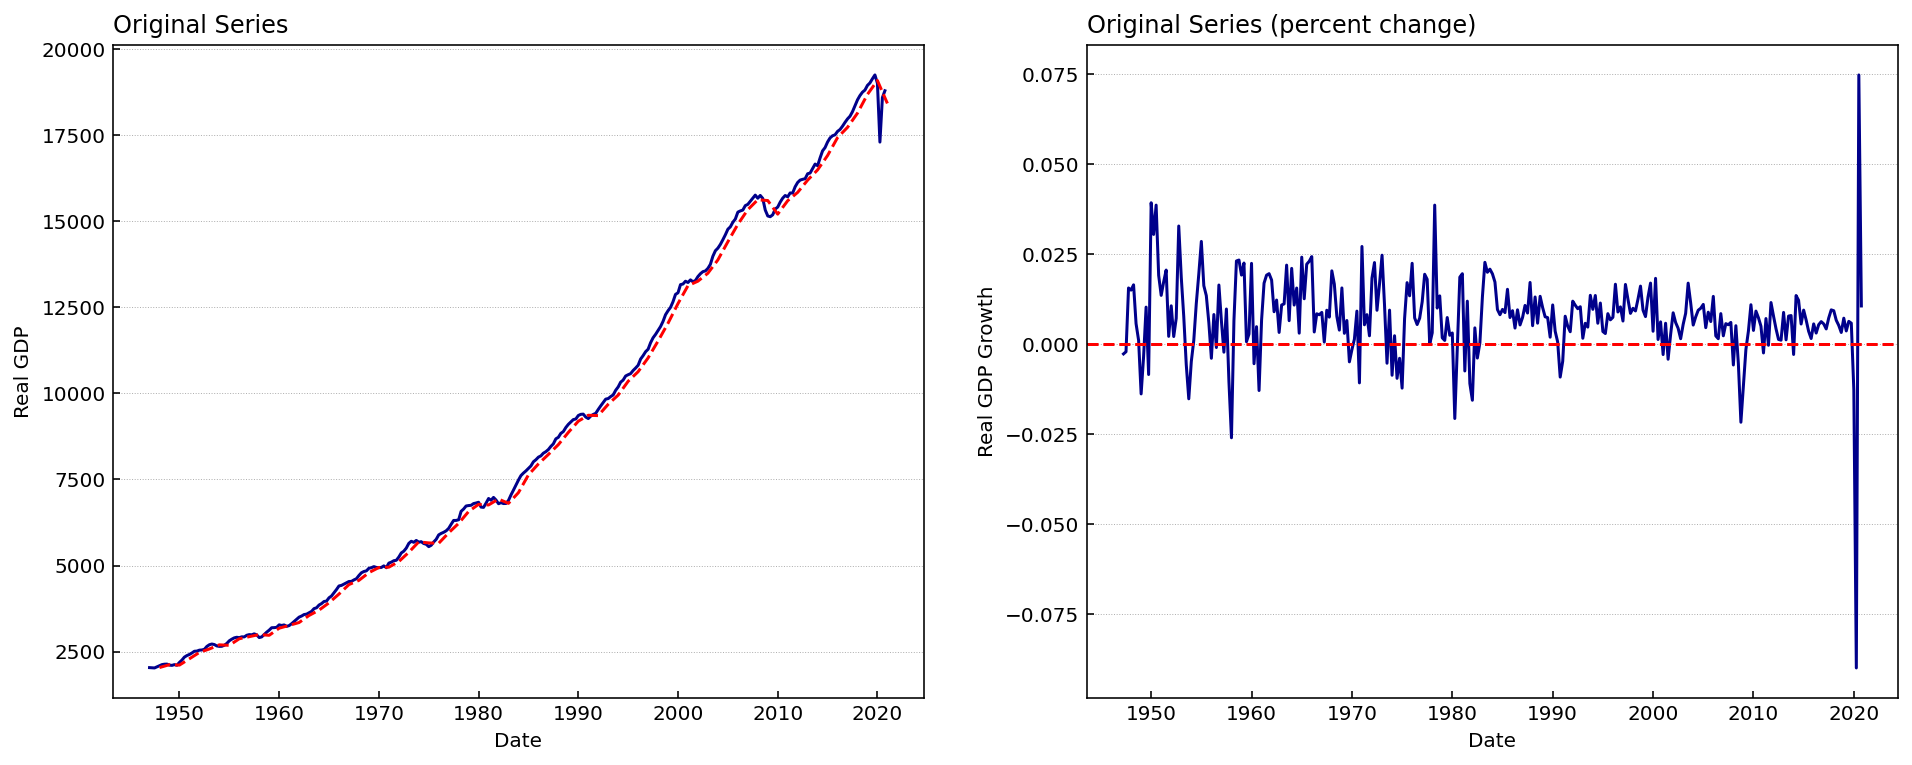

In [7]:
graph_plot(df)

## Data Decomposition

In [8]:
# seasonal_decompose(df, model = "multiplicative", period = 1)

## Stationarity Test

In [9]:
def adf_test(data):
    d = 0
    adf_test = adfuller(data.dropna(), regression = "c")
    test_statistic, p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
    while test_statistic > crit_value:
        data = data.diff()
        adf_test = adfuller(data.dropna(), regression = "c")
        test_statistic, p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
        d = d + 1
    else:
        print("test statistic: " + str(round(test_statistic, 2)))
        print("critical value: " + str(round(crit_value, 2)))
        print("p-value: " + str(round(p_value, 2)))
        print("-> order of differencing required: " + str(d))
    return d

In [10]:
d = adf_test(df)

test statistic: -7.97
critical value: -2.87
p-value: 0.0
-> order of differencing required: 1


In [11]:
def adf_plot(data, d = 0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    i = 0
    while i != d:
        data = data.diff().dropna()
        i = i + 1
    ax1.plot(data, color = "darkblue")
    ax1.axhline(y = 0, color = "red", linestyle = "--")
    ax1.set_xlabel("Date")
    ax1.set_title("Differenced Series (d=1)", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    plot_acf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
             vlines_kwargs = {"colors": "darkblue"}, lags = int(len(data)) - 1, use_vlines = False)
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Correlation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    for item in ax2.collections:
        if type(item) == PolyCollection:
            item.set_facecolor("blue")
    return data

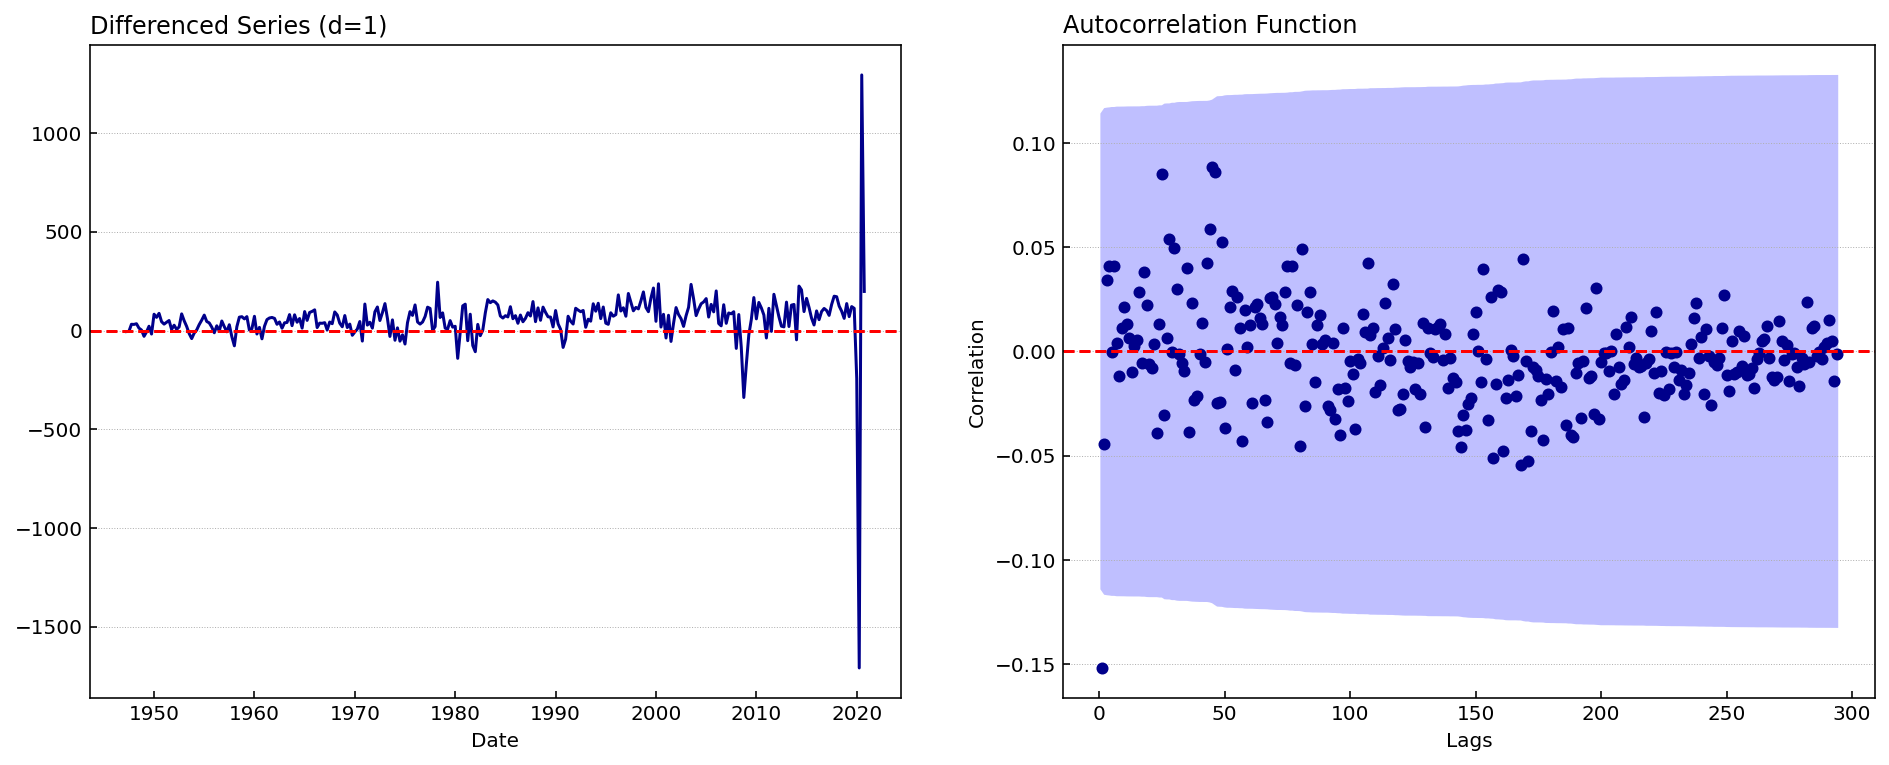

In [12]:
df_diff = adf_plot(df, d = 1)

## Export Training and Test Data

In [13]:
X = df.copy()
training_size = int(len(X) * 0.95)
training, testing = X[0:training_size], X[training_size:]

In [14]:
training.to_csv(os.getcwd() + "/Data/training.csv", index = True)
testing.to_csv(os.getcwd() + "/Data/testing.csv", index = True)